# Homework nr. 2 - data cleaning (deadline 8/11/2018)

In short, the main task is to clean The Metropolitan Museum of Art Open Access dataset.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do:

  1. Download the dataset MetObjects.csv from the repository https://github.com/metmuseum/openaccess/.
  2. Check consistency of at least three features where you expect problems (include "Object Name" feature).
  3. Select some features where you expect integrity problems (describe your choice) and check integrity of those features.
  4. Convert at least five features to a proper data type. Choose at least one numeric, one categorical and one datetime.
  5. Find some outliers (describe your selection criteria).
  6. Detect missing data in at least three features, convert them to a proper representation (if they are already not), and impute missing values in at least one feature.

**If you do all this properly, you will obtain 6 points**

To earn **extra two points** you can do some of these:
  * Focus more precisely on cleaning of the "Medium" feature. Such if you like to use it in KNN based algorithms later.
  * Focus on the extraction of physical dimensions of each item (width, depth and height in centimeters) from the "Dimensions" feature.

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
import numpy as np
import pandas as pd
import sklearn as skit
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency
from IPython.display import display, Markdown, Latex

import seaborn as sns
import re
import time

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('openaccess/MetObjects.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472127 entries, 0 to 472126
Data columns (total 43 columns):
Object Number              472127 non-null object
Is Highlight               472127 non-null bool
Is Public Domain           472127 non-null bool
Object ID                  472127 non-null int64
Department                 472127 non-null object
Object Name                468155 non-null object
Title                      441060 non-null object
Culture                    192200 non-null object
Period                     73147 non-null object
Dynasty                    23304 non-null object
Reign                      11212 non-null object
Portfolio                  21840 non-null object
Artist Role                281379 non-null object
Artist Prefix              96627 non-null object
Artist Display Name        282598 non-null object
Artist Display Bio         235113 non-null object
Artist Suffix              10742 non-null object
Artist Alpha Sort          282569 non-null object


* All of Object ID are different is good set is as row index.

In [4]:
df.index = df['Object ID']

## Consistency check and repair
### Check consistency of "Object Name" attribute:

In [72]:
#tmp = df['Object Name'].str.strip().str.len()
#display(tmp.describe())
#display(list(df.loc[tmp.nlargest(100).index]['Object Name']))
#display(df.loc[tmp.nsmallest(100).index]['Object Name'])
#display(list(df['Object Name'].unique()))

* "Object Name" have a lot of name with \n or \r\n characters.
* In most of the cases I came across, these characters are instead of spaces.
* Second problem in data what I find is ? or (?). 
* This can be used as a result of some uncertainty about the "Object name", 
I will leave this information in data, but I will make the embarrassment consistent with char (?).
* After repair \r\n there is some empty char will replace with nan.
* There are some two char name which can be bad, but there is not documetation for data. I will not replace it.
* Repair consistency of "Object Name" below

In [6]:
q_mark2 = re.compile(r'[?]+')
end_line1 = re.compile(r'\r\n+')
end_line2 = re.compile(r'\n+')
spaces = re.compile(r'[ ]+')
df['Object Name'] = df['Object Name'].str.replace("\(\?\)", '?').str.replace(q_mark2, '(?)')
df['Object Name'] = df['Object Name'].str.replace(end_line1, '\n').str.replace(end_line2, ' ')
df['Object Name'] = df['Object Name'].str.replace(spaces, ' ').str.strip()
df['Object Name'].replace([''], np.nan, inplace=True)

### Next check attribute for consistency is "Dynasty". Here I indicated inconsistencies in the slashes used:

In [7]:
display(df['Dynasty'].unique())

array([nan, 'Dynasty 8–11', 'Dynasty 12', 'early Dynasty 18', 'Dynasty 1',
       'Dynasty 18, early', 'Dynasty 6', 'Dynasty 5', 'Dynasty 4–5',
       'Dynasty 5–6', 'Dynasty 4–mid 5', 'Dynasty 4, mid–5th Dynasty',
       'Dynasty 4', 'Dynasty 3', 'Dynasty 12–13', 'Dynasty 6, first half',
       'Dynasty 6–8', 'Dynasty 6-8', 'Dynasty 4-6', 'early Dynasty 3',
       'Dynasty 11-12', 'Dynasty 18', 'Dynasty 27', 'Dynasty 12–17',
       'Dynasty 17–Early Dynasty 18', 'Dynasty 17–18', 'mid-Dynasty 18',
       'late Dynasty 12–early 13', 'late Dynasty 12–early  Dynasty 13',
       'Dynasty 12, late - early 13', 'Dynasty 13', 'Dynasty 11',
       'Dynasty 12, late–early 13',
       'Dynasty 12, late-13 up to 1700 B. C.', 'Dynasty 13–17',
       'late Dynasty 12–early Dynasty 13',
       'Dynasty 12, late–13 up to 1700 B. C.', 'Dynasty 12, late–13',
       'Dynasty 9 or later', 'Dynasty 9–10', 'Dynasty 9–11', 'Dynasty 17',
       'Second Intermediate Period', 'Dynasty 12, late - 13 up to 1700'

* Especially 
    * 'Dynasty 12, late - early 13'
    * 'Dynasty 12, late–early 13'
    * 'early dynasty 4–5'
    * 'Dynasty 29'
* Word dynasty will be remove, because is in column name
* Convert ? -> (?)
* Conver string to lower case
* Remove th, st, etc. after numbers
* Repair this consistency problem below

In [8]:
q_mark2 = re.compile(r'[?]+')
end_line1 = re.compile(r'\r\n+')
end_line2 = re.compile(r'\n+')
spaces = re.compile(r'[ ]+')
number = df['Dynasty'].nunique()
th = re.compile(r"(?<=\d)(st|nd|rd|th)\b")

df['Dynasty'] = df['Dynasty'].str.lower().str.replace("dynasty", '').str.replace("dyn", '')
df['Dynasty'] = df['Dynasty'].str.replace("\(\?\)", ' ? ').str.replace(q_mark2, ' (?) ')
df['Dynasty'] = df['Dynasty'].str.replace(end_line1, '\n').str.replace(end_line2, ' ')
df['Dynasty'] = df['Dynasty'].str.replace(spaces, ' ').str.strip()
df['Dynasty'] = df['Dynasty'].str.replace("–", '-').str.replace("- ", '-').str.replace(' -', '-').str.strip()
df['Dynasty'] = df['Dynasty'].str.replace(th, '')

display(Markdown("After repair consistency of values the number of unique decrease from \
                 " + str(number) + " to " +  str(df['Dynasty'].nunique())))

After repair consistency of values the number of unique decrease from                  377 to 296

### Next check attribute for consistency is "Medium":

In [9]:
display(list(df['Medium'].unique()))

['Gold',
 'Silver',
 'Bronze or copper',
 'Nickel',
 'Pressed glass',
 'Mahogany, laminated',
 'Gold, amethysts, spessartites, tourmalines, fresh water pearls, quartzes, rock crystal, and enamel',
 'Oak, tulip poplar',
 'Earthenware, basalt',
 'Paper',
 'Brass, iron',
 'Brass',
 'Iron',
 'Bell metal',
 'Bell metal, possibly iron',
 'Iron, brass',
 'Brass, steel',
 'Wrought iron',
 'Brass and iron',
 'Bronze, glass, iron',
 'Earthenware',
 'Earthenware, lusterware',
 'Bronze',
 'Wood, gilt',
 'Wood',
 'Wood, marble',
 'Limestone, ceramic, and Fravrile glass',
 'Sheffield plate, earthenware, glass',
 'Bronze, gilt brass',
 'Gilt bronze',
 'Glass',
 'Oak',
 'Maple, ash',
 'Maple',
 'Hard maple, soft maple, ash',
 'Maple, oak',
 'Graphite on off-white wove paper',
 'Poplar, ash',
 'Maple, cottonwood',
 'Oak, spruce, maple',
 'Pine, ash, maple',
 'Hickory, pine',
 'Beech',
 'Ash',
 'Mahogany',
 'Walnut, white cedar, yellow pine',
 'Maple, birch',
 'Primary: mahogany.  Secondary: cherry (med

* Here is the inconsistency mostly in the font size of the names, the first letter is always big, so for example Iron, oak are different from Oak, iron.
* Another problem is again the characters for line breaks.
* Furthermore, there is two separators "," or "and"
* Repair this consistency problem below

In [10]:
end_line1 = re.compile(r'\r\n+')
end_line2 = re.compile(r'\n+')
spaces = re.compile(r'[ ]+')
df['Medium'] = df['Medium'].str.lower().str.replace(" and ", ',').str.replace(",,", ',')
df['Medium'] = df['Medium'].str.replace(end_line1, '\n').str.replace(end_line2, ' ')
df['Medium'] = df['Medium'].str.replace(', ', ',').str.replace(',', ', ')
df['Medium'] = df['Medium'].str.replace(spaces, ' ').str.strip()

## Features with integrity problems
1. I think that data integrity problem can be found for example for attributes "Object Begin Date" and "Object End Date". There end date should be bigger than the start date. These dates are represented by year as int64.

2. Next integrity problems could be in Artist attributes. In this attributes are values for more artists separated by "|", so when I have 3 authors separated, there should be  for each of "Role", "Nationality", "Begin Date", "End Data", etc.  exist same count of values separate with "|" too.

3. Next may be if the city is in the specific country, region ... But this is necessary check externally.

### Check "Object Begin Date" and "Object End Date" integrity:

In [11]:
display((df[(df['Object Begin Date'] > df['Object End Date'])])[['Object Name', 
                                                                 'Object Begin Date', 'Object End Date']].head(10))

number = (df[(df['Object Begin Date'] > df['Object End Date'])])[['Object Name', 
                                                                 'Object Begin Date', 'Object End Date']].shape[0]
display(Markdown("Number of row which has \"Object Begin Date\"\
                 bigger than \"Object End Date\" is " + str(number) + " of " + str(df.shape[0])))
display(Markdown("There are several ways to solve this problem. \
                 For example, by replacing \"Artist End Date\" with value from begin or set to NaN or delete this rows."))

,Object Name,Object Begin Date,Object End Date
Object ID,,,
38468,Yaksha,-45,-55
55128,Print,1861,9
107853,Dolman,1875,1800
209514,Fan,1785,1779
229879,Sample and letter,1785,1773
237874,Fragments,1785,1779
243602,Ring with scarab,0,-5
247380,Lebes gamikos,-399,-3000
249163,Neck-amphora,-450,-475


Number of row which has "Object Begin Date"                 bigger than "Object End Date" is 198 of 472127

There are several ways to solve this problem.                  For example, by replacing "Artist End Date" with value from begin or set to NaN or delete this rows.

### Check Artists integrity problem:

In [12]:
x = lambda x: len(str(x).split("|")) if x is not np.nan else 0
number = df[((df['Artist Role'].apply(x) == df['Artist Display Name'].apply(x)) & 
       (df['Artist Display Bio'].apply(x) == df['Artist Alpha Sort'].apply(x)) &
       (df['Artist Begin Date'].apply(x) == df['Artist End Date'].apply(x)))].shape[0]

display(Markdown("Number of row, where the count of values in Artists atributes, is OK: " 
                 + str(number)))
display(Markdown("The value includes lines where are all values NaN."))

Number of row where is OK the count of values in Artists atributes: 392990

The value includes lines where all NaN values are present.

## Convert features to a proper data type.
### Convert "Credit Line" to text ('Credit Line From') and year ('Credit Line Year') if it is possible:
### Convert "Credit Line Year" to data time type:


In [13]:
def split(x):
    x = str(x).split(",")[-1].strip()
    if x.isdigit(): return x
    else: return np.nan
def removeYear(x):
    y = str(x).split(",")[-1].strip()
    if y.isdigit(): return ",".join(str(x).split(",")[:-1])
    else: return x
    
df['Credit Line Year'] = df['Credit Line'].apply(split)
df['Credit Line From'] = df['Credit Line'].apply(removeYear)
df['Credit Line Year'] = pd.to_datetime(df['Credit Line Year'], format='%Y', errors='coerce')

### Convert "Department" to categorical type:

In [14]:
df['Department'] = df['Department'].astype('category')

### Convert "Metadata Date" to datetime category:

In [15]:
df['Metadata Date'] = pd.to_datetime(df['Metadata Date'], format='%m/%d/%Y %H:%M:%S %p')

### Try to parse as much as possible "Dimensions" values to x,y,z, diameter and weight

In [53]:
t1 = re.compile(r'(?:(h\.|w\.|l\.)*(?:(?:.)*in[^\d]*|[^\d])*(\d*\.\d+|\d+)(cm|mm|m)*)'+
                '(?:x(h\.|w\.|l\.)*(\d*\.\d+|\d+)(cm|mm|m)*)?'+
                '(?:x(h\.|w\.|l\.)*(\d*\.\d+|\d+)(cm|mm|m)*)?')
t2 = re.compile(r'(?:(\d*\.\d+|\d+)(g|kg))')
t3 = re.compile(r'(diam)')

# Get weight in grams from regex find.
def matchWeight(x, previos):
    for i in x:
        if 'kg' in i[1]:
            return float(i[0])*1000
        if 'g' in i[1]:
            return float(i[0])
    return previos
    
# Propagation unit lefto to right whne was fill only on end.
def unitPropag(a, b, c):
    if a[-1] == '' and b[-1] == '':
        a[-1] = c[-1]
        b[-1] = c[-1]
        return
    if a[-1] == '':
        a[-1] = b[-1]
        return
    
# Convert lenght value to cm unit.
def convertLenghtUnit(x):
    if x[-1] == "m":
        return float(x[1])*100
    if x[-1] == 'mm':
        return float(x[1])/10
    if x[-1] == 'cm':
        return float(x[1])
    else: return np.nan

# Try to parse xyz. Lenght for x, Width for y and height for z.
def putXYZRight(ar, pos, x):
    if x[0] == 'h.':
        ar[2] = convertLenghtUnit(x)
        return
    if x[0] == 'w.':
        ar[1] = convertLenghtUnit(x)
        return
    if x[0] == 'l.':
        ar[0] = convertLenghtUnit(x)
    else:
        if ar[pos] is np.nan:
            ar[pos] = convertLenghtUnit(x)
        
# Try match units for regex match.
def matchSizes(ar, x):
    for i in x:
        a = list(i[:3])
        b = list(i[3:6])
        c = list(i[6:])
        if a[-1]=='cm' or b[-1]=='cm' or c[-1]=='cm' or\
            a[-1]=='m' or b[-1]=='m' or c[-1]=='m' or\
            a[-1]=='mm' or b[-1]=='mm' or c[-1]=='mm' :
            unitPropag(a,b,c)
            putXYZRight(ar, 0, a)
            putXYZRight(ar, 1, b)
            putXYZRight(ar, 2, c)
            return     
def getDim(x):
    # x, y, z, diam, weight
    sizes = [np.nan, np.nan, np.nan, np.nan, np.nan]  
    x = re.sub(re.compile(r'[ ]+'), '', re.sub(re.compile(r'\n+'), ';', re.sub(re.compile(r'\r\n+'), 
            '\n', str(x).lower()))).replace('×', 'x').strip().split(';')
    
    backup = x
    for i in x:
        # Magic remove for do faster big regex. For long string is too slow :( 
        # but with this is slow too, but successfull run done after few minutes.
        i = re.sub(re.compile(r'[a-z]{5,}'), ":", i)
        ar = [np.nan, np.nan, np.nan]
        if re.search(t3, i):
            matchSizes(ar, re.findall(t1, i))
            for j in ar:
                if j is not np.nan:
                    sizes[3] = j
            continue
        matchSizes(ar, re.findall(t1, i))
        for num, j in enumerate(ar):
            if sizes[num] is np.nan:
                sizes[num] = j
        sizes[-1] = matchWeight(re.findall(t2, i), sizes[-1])
    return "|".join(str(e) for e in sizes)

df["Parse Dimensions"] = df['Dimensions'].apply(getDim)

In [54]:
df["x"] = df["Parse Dimensions"].apply(lambda x: x.split("|")[0])
df["y"] = df["Parse Dimensions"].apply(lambda x: x.split("|")[1])
df["z"] = df["Parse Dimensions"].apply(lambda x: x.split("|")[2])
df["diameter"] = df["Parse Dimensions"].apply(lambda x: x.split("|")[3])
df["weight"] = df["Parse Dimensions"].apply(lambda x: x.split("|")[4])

In [55]:
df['x'] = df['x'].astype('double')
df['y'] = df['y'].astype('double')
df['z'] = df['z'].astype('double')
df['diameter'] = df['diameter'].astype('double')
df['weight'] = df['weight'].astype('double')

### Outlier detection
* Outliers can be detected on single feature or more features. 
* Bellow I try detect single value detection on "weight" feature. This values not have normal distribution for this detection, but from histogram can be seen that there can be some oversize values.
* For detection is use rule of thumb
* Outliers outside of interval (first quartile - 1.5 * IQR, second quartile + 1.5 * IQR) 
* IRQ is (second quartile - first quartile)
* So I try find values outside from interval on right and print some the biggest values. There will be many outliers which are not.
* There are some items which can be outliers, but it need check with other text attribute if this weight is possible.

,Object Number,Is Highlight,Is Public Domain,Object ID,Department,Object Name,Title,Culture,Period,Dynasty,Reign,Portfolio,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Object Date,Object Begin Date,Object End Date,Medium,Dimensions,Credit Line,Geography Type,City,State,County,Country,Region,Subregion,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Metadata Date,Repository,Credit Line Year,Credit Line From,Parse Dimensions,x,y,z,diameter,weight
Object ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
322609,32.143.2,True,True,322609,Ancient Near Eastern Art,Relief,Human-headed winged lion (lamassu),Assyrian,Neo-Assyrian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ca. 883–859 B.C.,-883,-859,gypsum alabaster,"H. 122 1/2 x W. 24 1/2 x D. 109 in., 15999.8 l...","Gift of John D. Rockefeller Jr., 1932",NaN,NaN,NaN,NaN,NaN,Mesopotamia,Nimrud (ancient Kalhu),NaN,NaN,NaN,NaN,Stone-Reliefs-Inscribed,NaN,http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",1932-01-01,Gift of John D. Rockefeller Jr.,311.2|62.2|276.9|nan|7257400.0,311.2,62.2,276.9,NaN,7257400.0
322608,32.143.1,True,True,322608,Ancient Near Eastern Art,Relief,Human-headed winged bull (lamassu),Assyrian,Neo-Assyrian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ca. 883–859 B.C.,-883,-859,gypsum alabaster,"H. 123 1/2 x W. 26 1/2 x D. 122 in., 15999.8 l...","Gift of John D. Rockefeller Jr., 1932",NaN,NaN,NaN,NaN,NaN,Mesopotamia,Nimrud (ancient Kalhu),NaN,NaN,NaN,NaN,Stone-Reliefs-Inscribed,NaN,http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",1932-01-01,Gift of John D. Rockefeller Jr.,313.7|67.3|309.9|nan|7257400.0,313.7,67.3,309.9,NaN,7257400.0
544442,31.3.166,True,True,544442,Egyptian Art,"Sphinx, Hatshepsut",Sphinx of Hatshepsut,NaN,New Kingdom,18,Joint reign of Hatshepsut and Thutmose III,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ca. 1479–1458 B.C.,-1473,-1458,"granite, paint",H: 164 cm (64 9/16 in.); L: 343 cm (135 1/16 i...,"Rogers Fund, 1931",From,NaN,NaN,NaN,Egypt,"Upper Egypt, Thebes",Deir el-Bahri,Senenmut Quarry,NaN,"MMA excavations, 1926–28",NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",1931-01-01,Rogers Fund,164.0|nan|nan|nan|6758600.0,164.0,NaN,NaN,NaN,6758600.0
34123,29.158.582,False,False,34123,Arms and Armor,Shield,Shield,"German, Augsburg",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ca. 1550,1525,1575,"steel, gold, brass",Diam. 20 3/4 in. (52.7 cm); Wt. 9 lb. 8 oz. (4...,"Bashford Dean Memorial Collection, Funds from ...",NaN,Augsburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shields,NaN,http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",1929-01-01,"Bashford Dean Memorial Collection, Funds from ...",nan|nan|nan|52.7|4309130.0,NaN,NaN,NaN,52.7,4309130.0
231245,10.129,False,False,231245,European Sculpture and Decorative Arts,Statue,Universal Peace,Russian,NaN,NaN,NaN,NaN,Artist|Founder,Cast by,Jules Leon Butensky|Roman Bronze Works,"Russian, 1871–1947",NaN,Butensky Jules Leon|Roman Bronze Works,Russian,1871,1947,ca. 1909–10,1904,1915,bronze,Overall: 106 1/4 in. (269.9 cm)\r\nCrate (base...,"Gift of Jacob H. Schiff, 1910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sculpture-Bronze,NaN,http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",1910-01-01,Gift of Jacob H. Schiff,269.9|190.5|167.6|nan|3810215.0,269.9,190.5,167.6,NaN,3810215.0


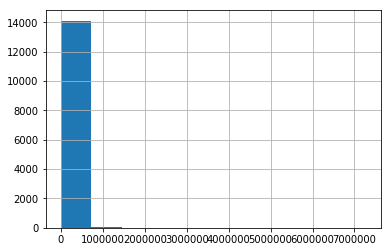

In [56]:
display(df['weight'].hist(bins=10))
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR =  Q3 - Q1
name = 'weight'
weightOut = (df[name] > Q3[name] + 1.5*IQR[name]) | (df[name] < Q1[name] - 1.5*IQR[name])
display(df[weightOut].sort_values([name], ascending = False).head())

#### Interesting detection of subscribers will be on more features. I'll try to detect the size of the objects.
* Criterium for select outliers in xyz i select KMeans with six centroids.
* I select outliers depend on distance from the nearest centroids.
* charts can be expanded by double-clicking

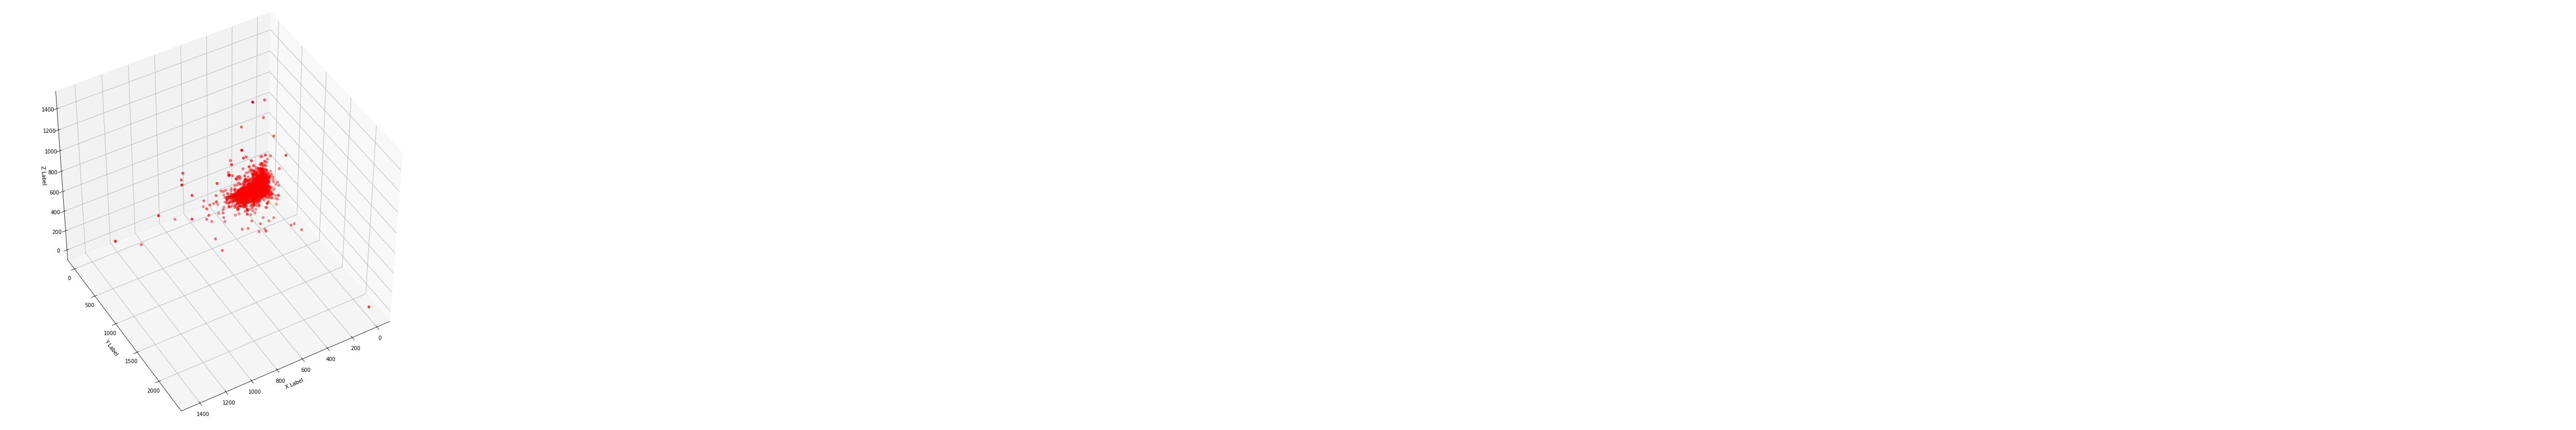

In [57]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, 60)
ax.scatter(df['x'], df['y'], df['z'], c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

,Object Number,Is Highlight,Is Public Domain,Object ID,Department,Object Name,Title,Culture,Period,Dynasty,Reign,Portfolio,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Object Date,Object Begin Date,Object End Date,Medium,Dimensions,Credit Line,Geography Type,City,State,County,Country,Region,Subregion,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Metadata Date,Repository,Credit Line Year,Credit Line From,Parse Dimensions,x,y,z,diameter,weight
Object ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
244140,74.51.5261,False,True,244140,Greek and Roman Art,Table offerings,Table offerings,Roman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-670,330,lead,Other: 1 7/16 in. × 76 ft. 5 in. × 3 in. (3.7 ...,"The Cesnola Collection, Purchased by subscript...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miscellaneous-Lead,NaN,http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",NaT,"The Cesnola Collection, Purchased by subscript...",3.7|2329.2|7.6|nan|nan,3.7,2329.2,7.6,NaN,NaN
7873,1972.60.1,True,False,7873,American Decorative Arts,Windows and Paneling,Living Room from the Francis W. Little House: ...,American,NaN,NaN,NaN,NaN,Maker,NaN,Frank Lloyd Wright,"American, Richland Center, Wisconsin 1867–1959...",NaN,"Wright, Frank Lloyd",American,1867,1959,1912–15,1912,1915,"oak, leaded glass",13 ft. 7 1/2 in. × 28 ft. 7 in. × 47 ft. 8 5/8...,"Purchase, Emily Crane Chadbourne Bequest, 1972",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Architecture,"© 2018 Artists Rights Society (ARS), New York",http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",1972-01-01,"Purchase, Emily Crane Chadbourne Bequest",415.3|871.2|1454.5|nan|nan,415.3,871.2,1454.5,NaN,NaN
196910,32.12,True,True,196910,European Sculpture and Decorative Arts,Period room,Dining room from Lansdowne House,British,NaN,NaN,NaN,NaN,Maker|Maker|Maker|Designer,Plaster ceiling by|Woodwork carved by|Marble c...,Joseph Rose|John Gilbert|John Devall & Co.|Rob...,"1746–1799|London|British, Kirkcaldy, Scotland ...",NaN,Rose Joseph|Gilbert John|John Devall & Co.|Ada...,"British, Scottish",1746 |1700 |1728,1799 |1800 |1792,1766–69,1766,1769,"wood, plaster, stone","Overall, room: H. 566 x W. 294 x D. 215in. (14...","Rogers Fund, 1931",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Woodwork,NaN,http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",1931-01-01,Rogers Fund,1437.6|746.8|546.1|nan|nan,1437.6,746.8,546.1,NaN,NaN
204561,65.164,False,True,204561,European Sculpture and Decorative Arts,Staircase balustrade,Staircase balustrade,British,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,probably ca. 1747,1742,1752,wrought iron,Assembled dim: H. (approx.) 35 ft. (10.675 m);...,"Purchase, Edward Pearce Casey Fund and Proceed...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Metalwork-Iron,NaN,http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",1965-01-01,"Purchase, Edward Pearce Casey Fund and Proceed...",1067.5|193.0|10.2|nan|nan,1067.5,193.0,10.2,NaN,NaN
35200,46.122.28,False,True,35200,Arms and Armor,Sword guard (Tsuba),Sword Guard (Tsuba),Japanese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,early 17th century,1601,1650,"iron, copper",H. 3 3/8 in. (8.6 m); W. 3 1/4 in. (8.3 cm); t...,"Funds from various donors, 1946",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sword Furniture-Tsuba,NaN,http://www.metmuseum.org/art/collection/search...,2018-10-22 08:00:01,"Metropolitan Museum of Art, New York, NY",1946-01-01,Funds from various donors,0.5|8.3|860.0|nan|99.2,0.5,8.3,860.0,NaN,99.2
196917,32.53.1,False,True,196917,European Sculpture and Decorative Arts,Period room,Dining room from Kirtlington Park,"British,

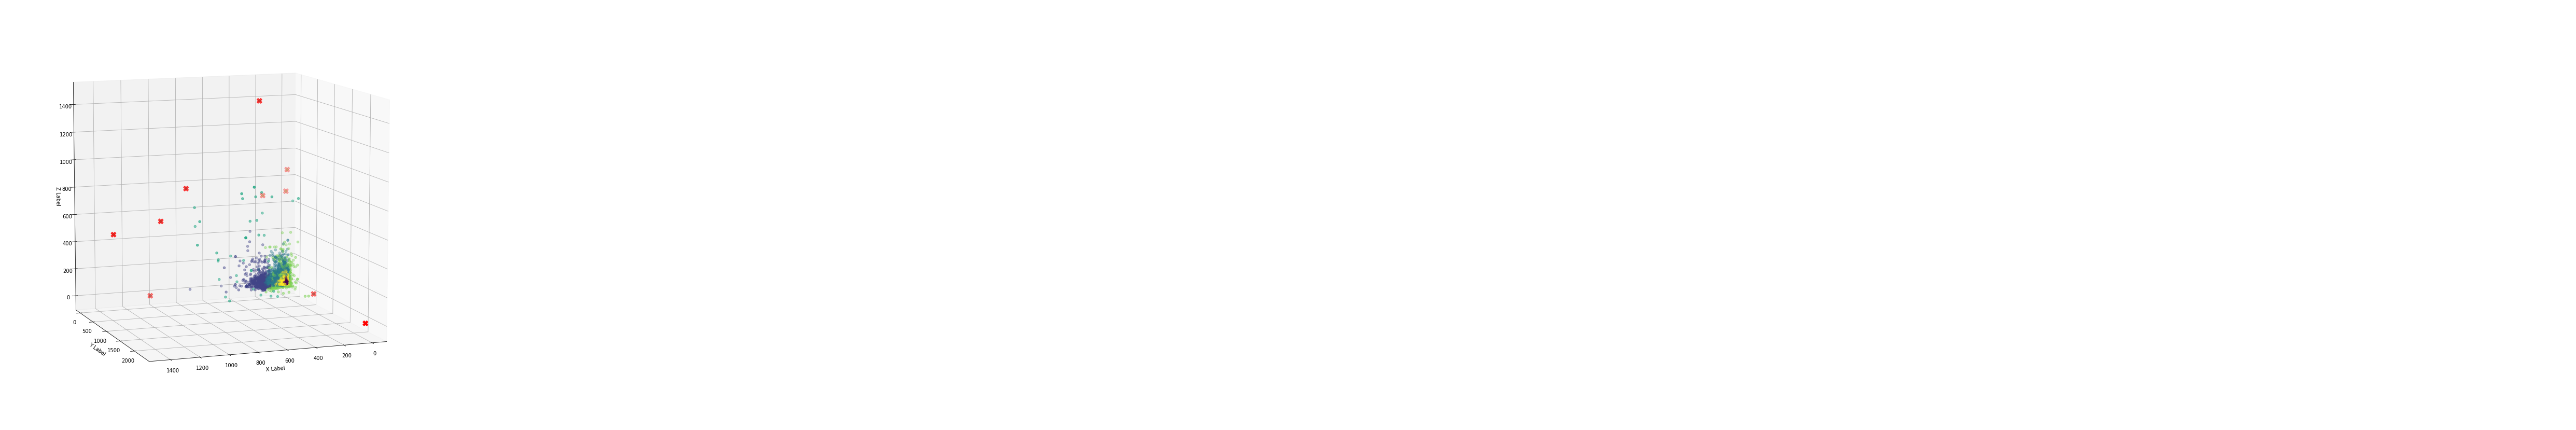

In [68]:
# K means clustering
data = df[['x', 'y', 'z']].dropna()
kmeans = KMeans(n_clusters=6, random_state=0).fit(data)

distances = kmeans.transform(data)
min_distances = pd.Series(np.apply_along_axis(min, 1, distances))

indices = data.iloc[min_distances.nlargest(10).index].index
pd.set_option('display.max_columns', 100)
display(df.loc[indices])
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 70)
ax.scatter(data.x, data.y, data.z, c=kmeans.labels_, marker='o')
ax.scatter(data.x[indices], data.y[indices], data.z[indices], c='r', marker='X', s=100)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### Detect missing values
* First missing values was in "Object Name" where I convert empty string to np.nan
* First I can see what attributes are now in dataset.
* Second missing value is in Title where was one value as " "
* Next I convert missing values to np.nan, when converting "Dimensions" to "x", "y", "z", "diameter" and "weight"

In [84]:
df['Title'].replace([' '], np.nan, inplace=True)
#name = 'Title'
#tmp = df[name].str.strip().str.len()
#display(tmp.describe())
#display(df.loc[tmp.nsmallest(100).index][name])
#display(list(df[name].unique()))

There are some columns which has some null value.

In [85]:
df.columns[df.isnull().any()]

Index(['Object Name', 'Title', 'Culture', 'Period', 'Dynasty', 'Reign',
       'Portfolio', 'Artist Role', 'Artist Prefix', 'Artist Display Name',
       'Artist Display Bio', 'Artist Suffix', 'Artist Alpha Sort',
       'Artist Nationality', 'Artist Begin Date', 'Artist End Date',
       'Object Date', 'Medium', 'Dimensions', 'Credit Line', 'Geography Type',
       'City', 'State', 'County', 'Country', 'Region', 'Subregion', 'Locale',
       'Locus', 'Excavation', 'River', 'Classification',
       'Rights and Reproduction', 'Credit Line Year', 'Credit Line From', 'x',
       'y', 'z', 'diameter', 'weight'],
      dtype='object')

### Inputing missing values
* When is x,y,z not null I try to predict weight using 3 nearest neighbors
* I replace mising(nan) value of x,y,z,diameter and new_weight with 0, which represent bad value, something cant have 0 size or weight.

In [ ]:
# choose columns to compute nearest neighbors
NNcolumns = ['x', 'y', 'z']
data = df.loc[:, NNcolumns].copy()
nanWeight_category = pd.api.types.CategoricalDtype(categories=[False, True], ordered=True)

df['NaNWeight'] = df['weight'].isnull()
df['NaNWeight'] = df['NaNWeight'].astype(nanWeight_category)
df['NaNXYZ'] = df['x'].notnull() & df['y'].notnull() & df['z'].notnull()
df['NaNXYZ'] = df['NaNXYZ'].astype(nanWeight_category)
# X - points where we know the weight
X = data[df.NaNWeight == False].values
Xidx = data[df.NaNWeight == False].index

# Y - points where the weight shoud be try to cound from x, y, z
Y = data[(df.NaNWeight == True) & (df.NaNXYZ == False)].values
Yidx = data[(df.NaNWeight == True) & (df.NaNXYZ == False)].index
print(Y.shape)
# training with 3 neighbours
neighbors = NearestNeighbors(3)
neighbors.fit(X)
print(X.shape)
# get 3 neighbors for each point
Yn = neighbors.kneighbors(Y, return_distance=False)
print(Yn.shape)

In [152]:
df['new_weight'] = df.weight
# Impute with mean of 5 nearest neighbours
for i in range(Yn.shape[0]):
    weights = [df.weight[Xidx[idx]] for idx in Yn[i,:]]
    df.loc[Yidx[i], 'new_weight'] = np.mean(weights)

KeyboardInterrupt: 

In [ ]:
df['x'].replace(np.nan, 0, inplace=True)
df['y'].replace(np.nan, 0, inplace=True)
df['z'].replace(np.nan, 0, inplace=True)
df['diameter'].replace(np.nan, 0, inplace=True)
df['new_weight'].replace(np.nan, 0, inplace=True)

In [ ]:
df.info()